In [59]:
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import numpy as np
import math
from math import atan2, pi, sqrt, cos, sin, tanh
from cmath import exp
from types import SimpleNamespace
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import interact
from matplotlib import ticker, cm
import time

from pylab import rcParams
rcParams['figure.figsize'] = 5,5

In [60]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
h_bar = h/(2*math.pi)
phi_0 = h/e #quantum de flux
k=0

In [61]:
def onsite(site):
    """
    potentiel de jonction pp
    """
    
    (x, y) = site.pos
    eta = -((y/10e-9)+1)

    if w == 0:
            return 0
    else:
        return -abs(Ef)*n/2*(math.tanh(eta*w)+ 1 )
    '''
    Jonction pp' (p'<p)
    0<n<1
    (p'>p)
    n>0
    
    Jonction pn'
    n<1
    
    Jonction pn
    n=2
    w = pente
    '''

In [62]:
def hopping(site_i, site_j):
    """
    Definition of the hopping parameter by including the magnetic field (parameter phi)

    """

    xi, yi = site_i.pos
    xj, yj = site_j.pos
    delta = (xi - xj) * (yi + yj)
    return -t * exp(-1j * math.pi * (phi/phi_0)* delta /( 3*np.sqrt(3)/(2) *alat**2))

In [63]:
def make_system(alat=1,W=1,L=1,t=1.0, h_l= 10, w_l=10,d_armEdge=10):
    graphene = kwant.lattice.honeycomb(alat,norbs=1)
    a, b = graphene.sublattices
    sys = kwant.Builder()
 
    def rectangular(pos):
        x, y = pos
        if (L-h_l)/2 < abs(y) < (L)/2:
            return abs(y) < (L)/2 and abs(x) < (W+w_l)/2
        return abs(x) < (W)/2 and abs(y) < (L+d_armEdge)/2 
    def lead_shape1(pos):
        x, y = pos
        return (L-h_l)/2 < abs(y) < L/2
  
    def lead_shape2(pos):
        x, y = pos
        return -W/2 < x < W/2
    
   
    
    sys[graphene.shape(rectangular, (0,0))] = onsite
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape1, (0, L/2))] = -pot
    lead0[graphene.neighbors()]= hopping
    sys.attach_lead(lead0)
    #sys.attach_lead(lead0.reversed())
    sys.attach_lead(lead0.reversed())
    
    sym1 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape1, (0, -L/2))] = -pot
    lead1[graphene.neighbors()]= hopping
    sys.attach_lead(lead1)
    sys.attach_lead(lead1.reversed())
    
    return sys

20


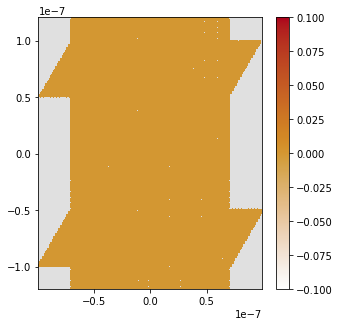

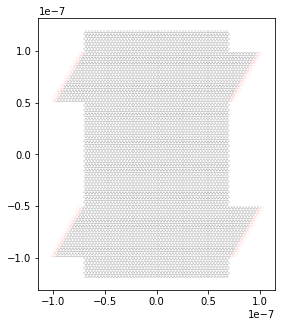

In [64]:
a0 = 0.142e-9  # réel
sf = 20 #scaling factor
alat = sf*a0 #scaled lattice factor
t0 = 2.8 ; #true hopping energy
n=0.0
w=1
t = t0/sf 
W = 7e-9*sf; L = 10e-9*sf # width and length of the electronic system: ordre de dimension 10e-7

N_p = -19.5e16 #densité de porteurs
Ef = -(3/2) * t * (alat) * np.sqrt(abs(np.pi*N_p))/sf
h_l = 5e-9*sf ; w_l = 0*sf ; d_armEdge =2e-9*sf 
print(sf)
k = 0
junctionType = 'pp'
pot= 0 # Valeur du potentiel
sys = make_system(alat,W,L,t, h_l, w_l,d_armEdge)

kwant.plotter.map(sys, onsite)
sys = sys.finalized()

kwant.plot(sys, site_size=alat)
B_coef = 4*2*h_bar*math.sqrt(math.pi)/(e*L)*10e13
Field = np.linspace(0, -1, 50)


In [65]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F = 3 * pi * alat * t / Ef # computation of the wavelength in graphene
print('Fermi wavelength: ', lambda_F)
print('Scaled lattice parameter: ', alat)
if lambda_F/alat < 2:
    print('Warning : lambda_F must be larger than the lattice parameter alat')
    
""" We must be at low energy density at the level of the Dirac cone """
print('Fermi energy Ef: ', Ef)
print('Enérgie max :', 3*t0*math.pi/sf)
print('Scaled hopping energy: ', t)
if abs(Ef/t) > (1/2):
    print('Warning : Ef must be smaller than (1/2)t')

Fermi wavelength:  -1.6055270315691722e-07
Scaled lattice parameter:  2.84e-09
Fermi energy Ef:  -0.023339947839678944
Enérgie max : 1.319468914507713
Scaled hopping energy:  0.13999999999999999


pn
Champ magnétique:  -1.25 T


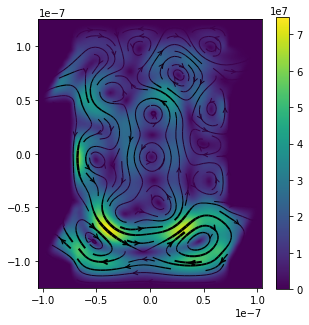

/home/jerem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [85]:
if(n > 0):
    print('pp', ' p2 > p1' )
    
elif(n<0 and n >-1):
    print('pp', ' p1> p2')
    
else :
    print('pn')
    
for B in [-1.25]:
    print('Champ magnétique: ', B, 'T')
    phi = B * 3*np.sqrt(3)/(2) *alat**2
    wfs = kwant.wave_function(sys, energy=Ef) # to obtain the wave functions of the system 
    J0 = kwant.operator.Current(sys)
    wf_left = wfs(0)
    current = sum(J0(p) for p in wf_left)
    kwant.plotter.current(sys, current, cmap='viridis');  


### Transmission normale (différence des 2 leads)

Densité 1 -1.95e+17
Densité 2 -1.9305e+17
Densité 3 -1.8712121212121213e+17
0
1
2
3
4
5
6
7
8
9
10
Boucle finie


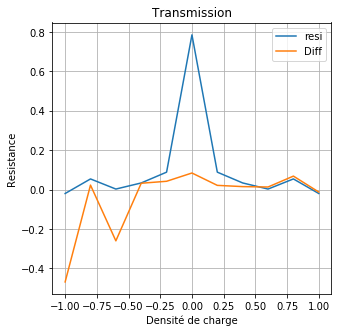

In [77]:
N=11
G2 = np.zeros(N)
G3 = np.zeros(N)
G4 = np.zeros(N)
Field = np.linspace(-1,1, N)
coeff = 99/100
coeff2 = 95/99 #coefficient pour la 2e énergie de Fermi
Ef2 = (3/2) * t * (alat) * np.sqrt(abs(np.pi*(N_p*coeff)))/sf 
Ef3 = (3/2) * t * (alat) * np.sqrt(abs(np.pi*(N_p*coeff2)))/sf
print('Densité 1', N_p)
print('Densité 2', N_p*coeff)
print('Densité 3', N_p*coeff2)
n = 2
B= 0
for i,po in enumerate(Field):
            print(i)
            B= po
            phi = B * 3*np.sqrt(3)/(2) *alat**2
            smatrix = kwant.smatrix(sys, energy = Ef)
            cm = smatrix.conductance_matrix()[:-1, :-1]
    
            
            G2[i] = np.linalg.solve(cm, [1, -1, 0])[2]

            """
            smatrix3 = kwant.smatrix(sys, energy = Ef3)
            T6 = smatrix3.transmission(2,0)
            T7 = smatrix3.transmission(3,0)
            G4[i] = T6-T7
            """
print("Boucle finie")            
plt.grid(True)            
plt.plot(Field,G2, label= "resi")

plt.plot(Field, G3, label = "Diff")
#plt.plot(Field, G4, label= N_p*coeff2)

plt.xlabel('Densité de charge')
plt.ylabel('Resistance')
plt.title("Transmission")
plt.legend()
plt.show()


## Résistance de Hall

Densité 1 -1.95e+17
Densité 2 -1.9305e+17
Densité 3 -1.8712121212121213e+17


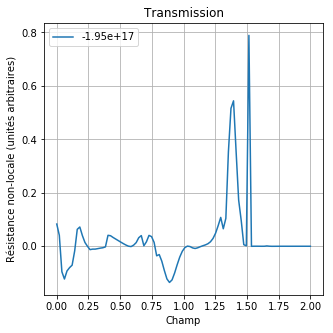

In [86]:
N=100
G2 = np.zeros(N)
G3 = np.zeros(N)
G4 = np.zeros(N)
Field = np.linspace(0, 2, N)
coeff = 99/100
coeff2 = 95/99 #coefficient pour la 2e énergie de Fermi
Ef2 = (3/2) * t * (alat) * np.sqrt(abs(np.pi*(N_p*coeff)))/sf 
Ef3 = (3/2) * t * (alat) * np.sqrt(abs(np.pi*(N_p*coeff2)))/sf
print('Densité 1', N_p)
print('Densité 2', N_p*coeff)
print('Densité 3', N_p*coeff2)
n = 0
for i,po in enumerate(Field):
            B = po
            phi = B * 3*np.sqrt(3)/(2) *alat**2
            smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)
            cm = smatrix.conductance_matrix()[:-1, :-1]
            G2[i] = np.linalg.solve(cm, [1, -1, 0])[2]
            nonlocal_resistance = np.linalg.solve(cm, [1, -1, 0])[2]


plt.grid(True)            
plt.plot(Field,G2, label= N_p)

plt.xlabel('Champ')
plt.ylabel('Résistance non-locale (unités arbitraires)')
plt.title("Transmission")
plt.legend()
plt.show()


In [339]:
B = 0.5
phi = B * 3*np.sqrt(3)/(2) *alat**2
smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)


# First we calculate the conductance matrix given the scattering matrix S
cond = np.array([[smatrix.transmission(i, j) for j in range(4)] for i in range(4)])
# Correct the reflection blocks, so that rows and columns sum to zero.
cond -= np.diag(cond.sum(axis=0))
# In order to calculate the nonlocal conductance we eliminate one row and one column 
# from the condutcance matrix. This amounts to setting the corresponding voltage to zero 
# and using current conservation to calculate the current through the last terminal.
cm = smatrix.conductance_matrix()[:-1, :-1]
# We then set the current to be 1 in the lead 0, -1 in lead 2, and
# calculate the voltage in lead 1 (so V_1 - V_3 since V_3 = 0).
nonlocal_resistance = np.linalg.solve(cm, [1, 0, -1])[1]

print(nonlocal_resistance)

0.16569545414883993


In [ ]:
TF = np.fft.rfft(G2)
TF = 1/(abs(TF))
plt.plot(TF)
plt.show()

In [ ]:

for B in [0.5]:
    for E in [Ef, Ef2, Ef3]:
        print('Champ magnétique: ', B, 'T')
        print('Energie de Fermi', E)
        phi = B * 3*np.sqrt(3)/(2) *alat**2
        wfs = kwant.wave_function(sys, energy=E) # to obtain the wave functions of the system 
        J0 = kwant.operator.Current(sys)
        wf_left = wfs(0)
        current = sum(J0(p) for p in wf_left)
        kwant.plotter.current(sys, current, cmap='viridis');  

## MAP (différence de transmission)

Temps écoulé:  0.00023627281188964844
0.0 %
Temps écoulé:  17.934932947158813
2.5 %
Temps écoulé:  40.76158952713013
5.0 %
Temps écoulé:  64.79886770248413
7.5 %
Temps écoulé:  86.47750234603882
10.0 %
Temps écoulé:  109.1161561012268
12.5 %
Temps écoulé:  136.72581815719604
15.0 %
Temps écoulé:  165.04234266281128
17.5 %
Temps écoulé:  188.63826608657837
20.0 %
Temps écoulé:  212.94368362426758
22.5 %
Temps écoulé:  235.7664830684662
25.0 %
Temps écoulé:  259.74090695381165
27.5 %
Temps écoulé:  282.366014957428
30.0 %
Temps écoulé:  305.473913192749
32.5 %
Temps écoulé:  328.5774972438812
35.0 %
Temps écoulé:  352.2458646297455
37.5 %
Temps écoulé:  375.10618710517883
40.0 %
Temps écoulé:  398.3831241130829
42.5 %
Temps écoulé:  420.55145144462585
45.0 %
Temps écoulé:  442.76167821884155
47.5 %
Temps écoulé:  467.5796797275543
50.0 %
Temps écoulé:  491.44392824172974
52.5 %
Temps écoulé:  514.3964891433716
55.0 %
Temps écoulé:  535.9750733375549
57.5 %
Temps écoulé:  557.739536523819

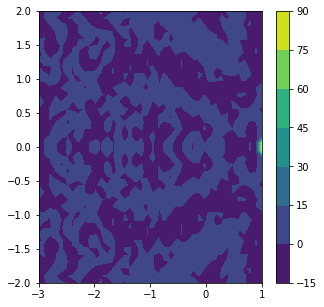

Temps d'exécution:  973.0245079994202


In [97]:
N= 40
Field = np.linspace(-2, 2, N)
Jonction = np.linspace(-3,1,N)
T = np.zeros((N,N))
start_time = time.time()
for i, I in enumerate(Field):

        print('Temps écoulé: ',time.time() - start_time)
        phi = I * 3*np.sqrt(3)/(2) *alat**2
        print(i*100/N, '%')
        for j, B in enumerate(Jonction):
            n = B
            smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)
            # In order to calculate the nonlocal conductance we eliminate one row and one column 
            # from the condutcance matrix. This amounts to setting the corresponding voltage to zero 
            # and using current conservation to calculate the current through the last terminal.
            cm = smatrix.conductance_matrix()[:-1, :-1]
        

            n2 = np.linalg.solve(cm, [1, -1 , 0])[2]
            T[i,j] = n2


plt.contourf(Jonction, Field, T);
plt.colorbar()
plt.show()
interval = time.time() - start_time  
print('Temps d\'exécution: ', interval)

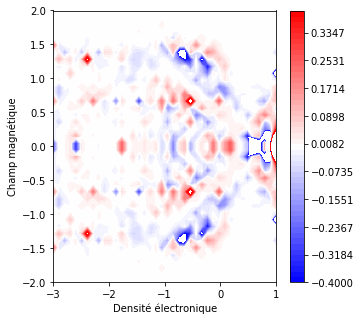

In [119]:
levels=np.linspace(-0.4,0.4,50)

plt.contourf(Jonction, Field, T,levels=levels, cmap='bwr');
plt.colorbar()
plt.xlabel("Densité électronique")
plt.ylabel("Champ magnétique")
plt.show()

In [54]:
f = open('map.txt','a')
f.write(str(Jonction))
f.write('\n Champ \n')
f.write(str( Field))
f.write('\n Transmission \n')
f.write(str(T))
f.close()


In [314]:
N= 50
Field = np.linspace(0, -2, N)
Jonction = np.linspace(-1,1,N)
T = np.zeros((N,N))
for i, I in enumerate(Jonction):
        n = I
        for j, B in enumerate(Field):
            phi = B * 3*np.sqrt(3)/(2) *alat**2
            smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)
            T2 = smatrix.transmission(2,0)
            T3 = smatrix.transmission(3,0)# transmission value obtained from the left lead towards the right lead
            T[i,j] = T2-T3
X = Jonction
Y = Field
plt.contourf(Jonction, Field, T)
    
    

KeyboardInterrupt: 